## Long-Term Memory - Remember Across Conversations
### Store User Preferences That Work Across All Threads

Learning Objectives:
- Understand short-term vs long-term memory
- Store user preferences across threads automatically
- Search memories with semantic search

#### Real-World Use Cases:
1. **Personal Assistants**: Remember preferences across all chats
2. **Customer Support**: Track customer info across tickets
3. **E-commerce**: Store shopping preferences
4. **Education**: Track learning progress

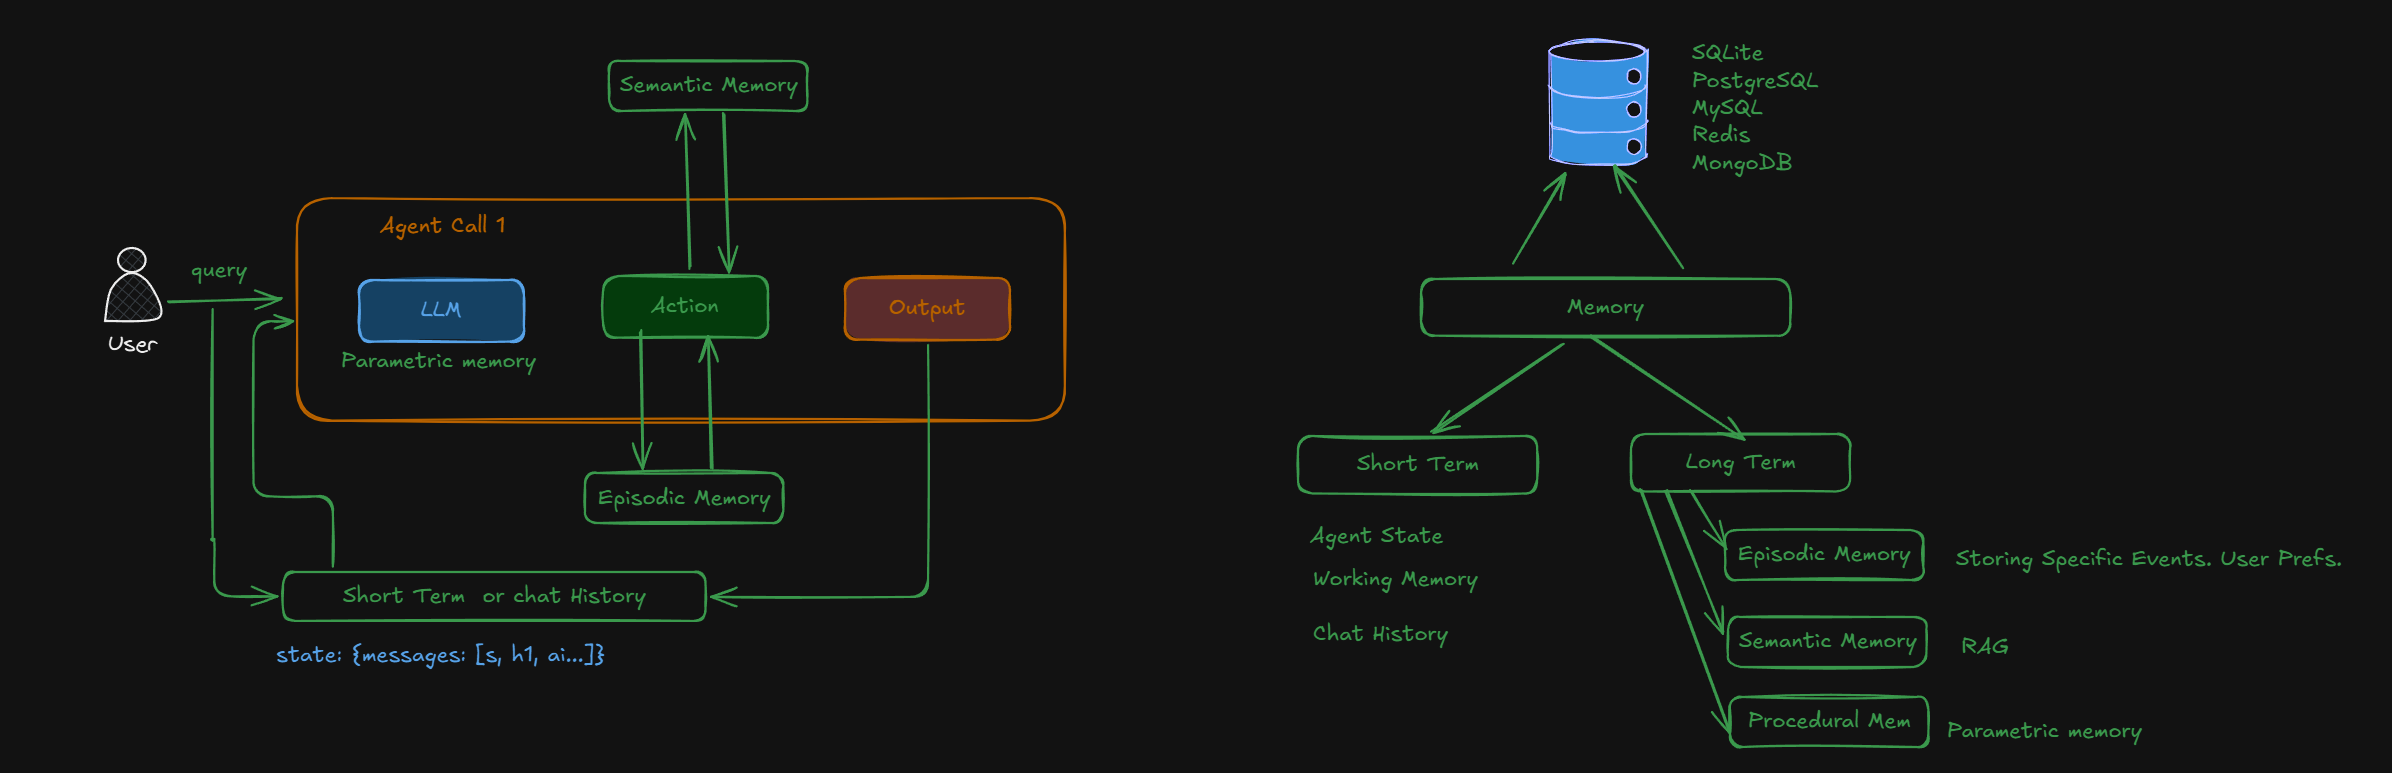

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END

# short term memory persistence
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.postgres import PostgresSaver

# long term memory persistence
from langgraph.store.postgres import PostgresStore
from langgraph.store.sqlite import SqliteStore

from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
import psycopg
import os

# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"
EMBEDDING_MODEL = "nomic-embed-text"

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

In [3]:
# =============================================================================
# Store and Saver Setup 
# =============================================================================

embeddings = OllamaEmbeddings(model=EMBEDDING_MODEL, base_url=BASE_URL)

def embed_texts(texts: list[str]) -> list[list[float]]:

    return embeddings.embed_documents(texts)

db_url = os.getenv("POSTGRESQL_URL")

checkpointer_conn = psycopg.connect(db_url, autocommit=True, prepare_threshold=0)
checkpointer = PostgresSaver(checkpointer_conn)

store_conn = psycopg.connect(db_url, autocommit=True, prepare_threshold=0)
store = PostgresStore(store_conn, index = {'embed': embed_texts, 'dims': 768})


# first time setup
checkpointer.setup()
store.setup()

## Tool usage - Memory Management Tools

In [4]:
# =============================================================================
# Demo 1: Store and Retrieve Memories
# =============================================================================

# Memory Operations: put(), get(), search(), delete()

user_id = "kgptalkie"
namespace = (user_id, "preferences")

store.put(namespace, "food", {"diet": "veg", 
                              "likes": ["pasta", "pizza", "veggies"]})


store.put(namespace, "color", {"favorite": "blue", 
                               "dislike": "brown"})

store.put(namespace, "work", {
    "role": "Data Scientist",
    "interests": ["machine learning", "ai", "gen ai", "agents"]
})



In [5]:
store.get(namespace, "color")

Item(namespace=['kgptalkie', 'preferences'], key='color', value={'dislike': 'brown', 'favorite': 'blue'}, created_at='2025-11-06T17:54:06.587068+00:00', updated_at='2025-11-06T17:54:06.587068+00:00')

In [6]:
# be careful
store.delete(namespace, "color")

In [7]:
# =============================================================================
# Demo 2: Semantic Search
# =============================================================================

query = "What does kgp talkie like to eat?"
results = store.search(namespace, query=query, limit=1)
results

[Item(namespace=['kgptalkie', 'preferences'], key='food', value={'diet': 'veg', 'likes': ['pasta', 'pizza', 'veggies']}, created_at='2025-11-06T09:46:57.726747+00:00', updated_at='2025-11-06T17:54:06.276885+00:00', score=0.5786444826046763)]

In [8]:
query = "What does kgp talkie like in colors?"
results = store.search(namespace, query=query, limit=1)
results

[Item(namespace=['kgptalkie', 'preferences'], key='food', value={'diet': 'veg', 'likes': ['pasta', 'pizza', 'veggies']}, created_at='2025-11-06T09:46:57.726747+00:00', updated_at='2025-11-06T17:54:06.276885+00:00', score=0.42101958236507275)]

In [9]:
# State Definition

class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    user_id: str

In [10]:
# =============================================================================
# Tools for Memory Management
# =============================================================================

# save user memory and get user memory

@tool
def save_user_memory(user_id:str, category:str, information:dict) -> str:
    """
    Save user preference or information to long-term memory.

    Args:
        user_id: User identifier
        category: Category of information (e.g., 'food', 'work', 'hobbies', 'schedule', 'location')
        information: Dictionary containing the information to save
    """

    namespace = (user_id, "preferences")

    store.put(namespace, category, information)

    return f"Saved {category} preferences."


In [11]:
# if you want to use store.search
# @tool
# def get_user_memory(user_id:str, query:str) -> str:
# store.search(namespace, query)

In [12]:
@tool
def get_user_memory(user_id:str, category:str) -> str:
    """
        Retrieve user preference or information from long-term memory.

        Args:
            user_id: User identifier
            category: Category of information to retrieve (e.g., 'food', 'work', 'hobbies')
        """
    
    namespace = (user_id, "preferences")

    item = store.get(namespace, category)

    if item:
        return f"{category}: {item.value}"
    else:
        return f"No '{category}' information found!"
    

In [13]:
get_user_memory.invoke({"user_id": 'kgptalkie', "category": 'color'})

"No 'color' information found!"

In [14]:
get_user_memory.invoke({"user_id": 'kgptalkie', "category": 'something'})

"No 'something' information found!"

### Agent with Automatic Memory Storage

In [15]:
## Tool usage
import sys
sys.path.append("../05. LangGraph ReAct Agent with Tools")

import my_tools

# my_tools.get_weather.invoke({'location': "Mumbai"})

my_tools.calculate.invoke({'expression': '2+2*1.4/23-34'})

all_tools = [my_tools.get_weather, my_tools.calculate]

[TOOL] calculate ('2+2*1.4/23-34') -> '-31.878260869565217'


In [16]:
# =============================================================================
# Agent Node with Automatic Memory
# =============================================================================

def agent_node(state: AgentState):

    store_conn = psycopg.connect(db_url, autocommit=True, prepare_threshold=0)
    store = PostgresStore(store_conn, index = {'embed': embed_texts, 'dims': 768})

    user_id = state.get("user_id", "unknown")
    namespace = (user_id, "preferences")

    last_message = state['messages'][-1].content
    memories = store.search(namespace, query=last_message, limit=3)

    # build context memory for personalized answer
    context_line = []
    for mem in memories:
        text = f" -{mem.key}: {mem.value}"
        context_line.append(text)

    memory_text = "\n\n".join(context_line) if context_line else "No user preferences stored yet!"

    print(f"User Memory Retrieved: \n{memory_text}\n")

    tools = all_tools + [save_user_memory, get_user_memory]

    llm_with_tools = llm.bind_tools(tools)

    system_prompt = SystemMessage(f"""
                        You are a helpful assistant with long-term memory capabilities and access to utility tools.

                            User ID: {user_id}
                            Current User Memories:
                            {memory_text}

                            MEMORY TOOLS USAGE:

                            1. save_user_memory: Use when user shares NEW information
                            - Always pass user_id: "{user_id}"
                            - Food preferences (diet, likes, dislikes, allergies)
                            - Work information (role, company, interests)
                            - Hobbies and activities
                            - Schedule and availability
                            - Location and timezone

                            2. get_user_memory: Use when you need to recall specific category
                            - Always pass user_id: "{user_id}"
                            - When answering questions about past preferences
                            - When user asks "what do you know about me?"
                            - When making recommendations based on preferences

                            UTILITY TOOLS USAGE:

                            3. get_weather: Use to retrieve current weather information
                            - Pass location as parameter (city name, zip code, or coordinates)
                            - Use when user asks about weather conditions
                            - Use when planning activities that depend on weather
                            - Examples: "What's the weather in London?", "Will it rain today?"

                            4. calculate: Use to perform mathematical calculations
                            - Pass mathematical expression as string parameter
                            - Supports basic arithmetic (+, -, *, /)
                            - Supports advanced operations (powers, roots, trigonometry)
                            - Use when user needs numerical computations
                            - Examples: "What's 15% of 250?", "Calculate the area of a circle with radius 5"

                            GUIDELINES:
                            - Always save when user shares personal information
                            - Retrieve specific categories when needed for context
                            - Use semantic search results shown above for general context
                            - Use get_weather when location-based weather info is needed
                            - Use calculate for any mathematical operations or conversions
                            - Be conversational and natural when using all tools
                            - Combine tools when appropriate (e.g., weather + saved location preference)
                        """)
    
    messages = [system_prompt] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[AGENT] Responding...")


    return {'messages': [response]}


In [17]:
# Routing
def should_continue(state: AgentState):
    last = state['messages'][-1]
    
    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    else:
        return END

In [18]:
# =============================================================================
# Graph
# =============================================================================
from langgraph.prebuilt import ToolNode

tools = all_tools + [save_user_memory, get_user_memory]

def create_agent():

    builder = StateGraph(AgentState)

    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode(tools))


    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent", should_continue, ["tools", END])

    builder.add_edge("tools", "agent")

    checkpointer_conn = psycopg.connect(db_url, autocommit=True, prepare_threshold=0)
    checkpointer = PostgresSaver(checkpointer_conn)
    graph = builder.compile(checkpointer=checkpointer)

    return graph

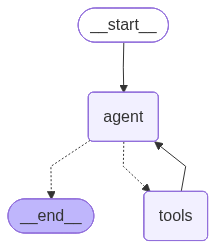

In [19]:
agent = create_agent()
agent

In [20]:
user_id = "kgptalkie"
config = {'configurable': {'thread_id': f"{user_id}_longterm"}}

query = "I am Laxmi kant tiwari. I love AI and machine learning in python."

result = agent.invoke({'messages': [HumanMessage(query)],
                       'user_id': user_id}, config=config)

User Memory Retrieved: 
 -work: {'role': 'Data Scientist', 'interests': ['machine learning', 'ai', 'gen ai', 'agents']}

 -food: {'diet': 'veg', 'likes': ['pasta', 'pizza', 'veggies']}

[AGENT] Responding...


In [23]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

It seems you're introducing yourself as Laxmi Kant Tiwari! However, the user ID associated with your previous interactions is "kgptalkie". If you'd like to update your profile or share new information (e.g., work details, food preferences, etc.), let me know! For now, I’ll continue using "kgptalkie" as your identifier. How can I assist you today with AI, machine learning, or Python? 😊


In [24]:
user_id = "kgptalkie"
config = {'configurable': {'thread_id': f"{user_id}_longterm"}}

query = "Could you please suggest me some diet plan?"

result = agent.invoke({'messages': [HumanMessage(query)],
                       'user_id': user_id}, config=config)

result['messages'][-1].pretty_print()

User Memory Retrieved: 
 -food: {'diet': 'veg', 'likes': ['pasta', 'pizza', 'veggies']}

 -work: {'role': 'Data Scientist', 'interests': ['machine learning', 'ai', 'gen ai', 'agents']}

[AGENT] called Tool get_user_memory with args {'category': 'food', 'user_id': 'kgptalkie'}
User Memory Retrieved: 
 -food: {'diet': 'veg', 'likes': ['pasta', 'pizza', 'veggies']}

 -work: {'role': 'Data Scientist', 'interests': ['machine learning', 'ai', 'gen ai', 'agents']}

[AGENT] Responding...
================================== Ai Message ==================================

Here’s a vegetarian diet plan tailored to your preferences (veg diet, loves pasta, pizza, and veggies):

### **Breakfast Ideas**  
- **Whole grain pasta with tomato sauce** + a side of steamed veggies (e.g., broccoli, carrots).  
- **Oatmeal** topped with fresh fruits (e.g., berries, banana) and a sprinkle of nuts.  
- **Veggie omelet** (using spinach, mushrooms, and bell peppers) with whole wheat toast.  

### **Lunch Options** 

In [25]:
user_id = "kgptalkie"
config = {'configurable': {'thread_id': f"{user_id}_this_is_another_test"}}

query = "Could you please suggest me some diet plan?"

result = agent.invoke({'messages': [HumanMessage(query)],
                       'user_id': user_id}, config=config)

result['messages'][-1].pretty_print()

User Memory Retrieved: 
 -food: {'diet': 'veg', 'likes': ['pasta', 'pizza', 'veggies']}

 -work: {'role': 'Data Scientist', 'interests': ['machine learning', 'ai', 'gen ai', 'agents']}

[AGENT] called Tool get_user_memory with args {'category': 'food', 'user_id': 'kgptalkie'}
User Memory Retrieved: 
 -food: {'diet': 'veg', 'likes': ['pasta', 'pizza', 'veggies']}

 -work: {'role': 'Data Scientist', 'interests': ['machine learning', 'ai', 'gen ai', 'agents']}

[AGENT] Responding...
================================== Ai Message ==================================

Here's a vegetarian diet plan incorporating your preferences for pasta, pizza, and veggies:

**Breakfast Ideas:**
- Veggie omelet with whole grain toast (spinach, tomatoes, onions)
- Pasta breakfast scramble (whole wheat pasta with veggies and vegan cheese)
- Fruit smoothie with spinach or frozen berries

**Lunch Options:**
- Veggie pizza with whole wheat crust, tomato sauce, and your favorite toppings
- Quinoa salad with roasted